# Imports and setting up viz

NB : conda env1 on Mac, lam1env on spirit (Python3.12)

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

#import personnal tools
from tools import *

# Load files

LAM output analysis.

Simu irr et simu no-irr.

In [2]:
noirr_dir='../../../JZ_simu_outputs/LAM/noirr_2010_2022'
irr_dir='../../../JZ_simu_outputs/LAM/irr_2010_2022'

In [3]:
#open netcdf files for native routing on ORC grid
filename = '{}/SRF/MO/*history.nc'.format(noirr_dir)
ORCnoirr0 = xr.open_mfdataset(filename)
ORCnoirr = ORCnoirr0.rename({'time_counter':'time'})
ORCnoirr.attrs['name'] = 'no_irr'
ORCnoirr = ORCnoirr.sel(lon=slice(-13,6),lat=slice(32,49))


In [4]:
filename = '{}/SRF/MO/*history.nc'.format(irr_dir)
ORCirr0 = xr.open_mfdataset(filename)
ORCirr = ORCirr0.rename({'time_counter':'time'})
ORCirr.attrs['name'] = 'irr'
ORCirr = ORCirr.sel(lon=slice(-13,6),lat=slice(32,49))

#manually define irrig_deficit as netirrig-irrigation in ORC file
ORCirr['irrig_deficit'] = ORCirr['netirrig'] - ORCirr['irrigation']
#make irrig_deficit units mm/day
ORCirr['irrig_deficit'].attrs['units'] = 'mm/day'
ORCirr['irrig_frac'] = ORCirr['irrigmap_dyn']/ORCirr['Areas']

ORCirr0

<xarray.Dataset>
Dimensions:                 (lat: 232, lon: 300, veget: 15, soiltyp: 3,
                             solth: 18, nobio: 1, solay: 11, albtyp: 2,
                             time_counter: 156, axis_nbounds: 2)
Coordinates:
  * lat                     (lat) float32 30.0 30.09 30.17 ... 49.83 49.91 50.0
  * lon                     (lon) float32 -13.0 -12.93 -12.86 ... 7.86 7.93 8.0
  * veget                   (veget) float32 1.0 2.0 3.0 4.0 ... 13.0 14.0 15.0
  * soiltyp                 (soiltyp) float32 1.0 2.0 3.0
  * solth                   (solth) float32 0.0004888 0.001955 ... 33.53 65.56
  * nobio                   (nobio) float32 1.0
  * solay                   (solay) float32 0.0 0.001955 0.005865 ... 0.999 2.0
  * albtyp                  (albtyp) float32 1.0 2.0
    time_centered           (time_counter) datetime64[ns] dask.array<chunksize=(1,), meta=np.ndarray>
  * time_counter            (time_counter) datetime64[ns] 2010-01-16T12:00:00...
Dimensions without coordinates: axis_nbounds
Data variables: (12/127)
    time_centered_bounds    (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    time_counter_bounds     (time_counter, axis_nbounds) datetime64[ns] dask.array<chunksize=(1, 2), meta=np.ndarray>
    Areas                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    Contfrac                (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    swnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    lwnet                   (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    ...                      ...
    DelSWE_daily            (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delfastr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delslowr_daily          (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstreamr_daily        (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    delstock_routing_daily  (time_counter, lat, lon) float32 dask.array<chunksize=(1, 232, 300), meta=np.ndarray>
    soilalb_bg              (time_counter, albtyp, lat, lon) float32 dask.array<chunksize=(1, 2, 232, 300), meta=np.ndarray>
Attributes:
    name:         sechiba_history
    description:  Created by xios
    title:        Created by xios
    Conventions:  CF-1.6
    timeStamp:    2024-Apr-08 20:56:20 GMT
    uuid:         1bf4f5bf-aaac-446e-96f9-b10623398784

In [5]:
# Select the JJA months (June, July, August)
months=[6, 7, 8]
ORCirr = ORCirr.sel(time=ORCirr['time.month'].isin(months))
ORCnoirr = ORCnoirr.sel(time=ORCnoirr['time.month'].isin(months))

In [6]:
#open netcdf files for native routing diag_routing_r.nc (on MERIT grid)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(noirr_dir)
# DIAGRnoirr0 = xr.open_mfdataset(filename)
# filename = '../../LAM/{}/SRF/MO/*diag_routing_r.nc'.format(irr_dir)
# DIAGRirr0 = xr.open_mfdataset(filename)
# DIAGRirr0

#rename time_counter to time all files
# DIAGRnoirr = DIAGRnoirr0.rename({'time_counter':'time'})
# DIAGRirr = DIAGRirr0.rename({'time_counter':'time'})

#Change dataset names attribute for automatic labeling
# DIAGRirr.attrs['name'] = 'DIAGR_irr'
# DIAGRnoirr.attrs['name'] = 'DIAGR_noirr'

#Rename variables in natDIAG_R_month and natDIAG_R
# dict = {
#         'routing_stream_reservoir_r' : 'streamr',
#         'routing_fast_reservoir_r' : 'fastr',
#         'routing_slow_reservoir_r' : 'slowr',
#         'routing_drainage_r' : 'drainage',
#         'routing_runoff_r' : 'runoff',
#         'routing_hydrographs_r' : 'hydrographs',
#         # 'routing_irrigation_r' : 'irrigation',
#         # 'irrig_netereq_r' : 'netirrig'
#         # 'routing_riverflow_r' : 'riverflow',
#         # 'routing_coastalflow_r' : 'coastalflow'
#         }
#change the variables that exist according to the dictionary
# DIAGRnoirr = DIAGRnoirr.rename(dict)
# DIAGRirr = DIAGRirr.rename(dict)

## Masks

In [7]:
#create a masks of data points where irrig_frac >5%
irr_mask = (ORCirr['irrigmap_dyn']/ORCirr['Areas'])>0.05

In [8]:
mORCirr=ORCirr.where(irr_mask)
mORCirr.attrs['name'] = 'irr'

mORCnoirr=ORCnoirr.where(irr_mask)
mORCnoirr.attrs['name'] = 'no_irr'

# Maps

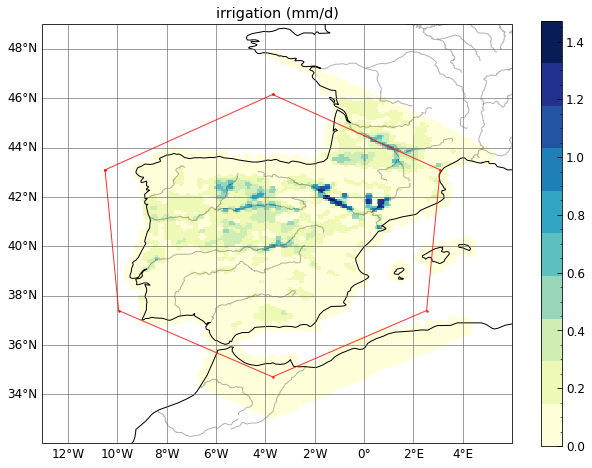

In [9]:
ds=ORCirr
var='irrigation'
map_ave(ds, var, in_cmap=wet, hex=True)

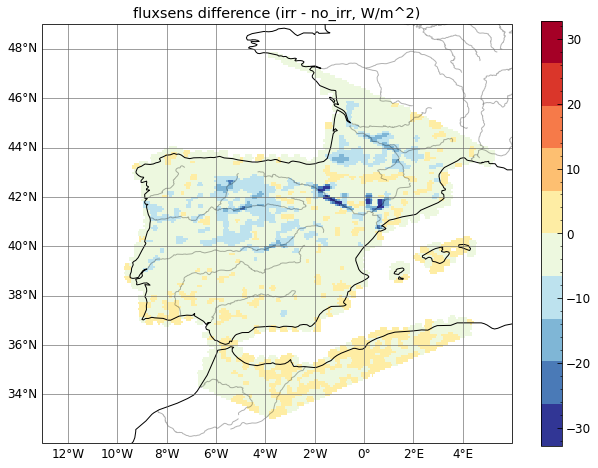

In [10]:
#diff
ds1=ORCirr
ds2=ORCnoirr
var='fluxsens'
map_diff_ave(ds1, ds2, var)

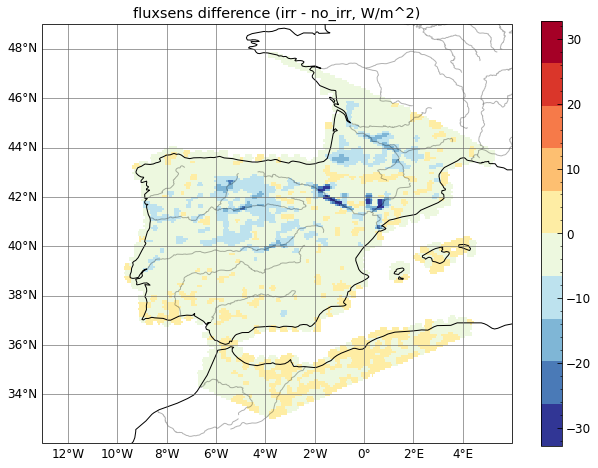

In [11]:
#diff with significance (not ready with ORC yet...)
ds1=ORCirr
ds2=ORCnoirr
var='fluxsens'
map_diff_ave(ds1, ds2, var, sig=False)

In [12]:
#Diff map with significance
var='evap'
max_value=None
ds1=ORCirr
ds2=ORCnoirr
# ds1=DIAGRirr
# ds2=DIAGRnoirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time') #* 3600 * 24

p_values = xr.apply_ufunc(
    lambda x, y: ttest_ind(x, y, axis=0, nan_policy='omit').pvalue, 
    ds1[var], ds2[var],
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
mask=p_values<0.05

#display map
fig = plt.figure(figsize=(10, 7.5))
ax = plt.axes(projection=ccrs.PlateCarree())
# gridline setup
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)

# diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
diff.where(mask).plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=max_value)
plt.title(var + ' difference (' + ds1.name + ' - ' + ds2.name + ', ' + ds1[var].attrs['units'] + ')')
# plt.title('Precipitation difference (irr - no_irr, April to September, mm/day)')

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [ ]:
#pvalue plot
var='evap'
min_value=0
max_value=None
ds1=ORCirr
ds2=ORCnoirr
p_values = xr.apply_ufunc(
    lambda x, y: ttest_ind(x, y, axis=0, nan_policy='omit').pvalue, 
    ds1[var], ds2[var],
    input_core_dims=[['time'], ['time']],
    output_core_dims=[[]],
    vectorize=True,
    dask='parallelized',
    output_dtypes=[float]
)
p_values

ValueError: dimension time on 0th function argument to apply_ufunc with dask='parallelized' consists of multiple chunks, but is also a core dimension. To fix, either rechunk into a single array chunk along this dimension, i.e., ``.chunk(dict(time=-1))``, or pass ``allow_rechunk=True`` in ``dask_gufunc_kwargs`` but beware that this may significantly increase memory usage.

In [ ]:
# Display 2 maps of var
var = 'flat'
maxvalue=2
color_map=reds

ds1 = ORCirr
ds2 = ORCnoirr
# ds1=DIAGRirr
# ds2=DIAGRnoirr
plotvar_1 = ds1[var].mean(dim='time') *3600*24
plotvar_2 = ds2[var].mean(dim='time') #*3600*24

# Create a figure with two subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(12, 4), subplot_kw={'projection': ccrs.PlateCarree()})
fig.suptitle(var + ' ({})'.format(ds1[var].units))

# Plot for std dataset
axs[0].coastlines()
plotvar_1.plot(ax=axs[0], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[0].set_title(f'{var} ({ds1.name})')

# Plot for natORC dataset
axs[1].coastlines()
plotvar_2.plot(ax=axs[1], transform=ccrs.PlateCarree(), cmap=color_map, vmax=maxvalue)
axs[1].set_title(f'{var} ({ds2.name})')

KeyError: 'flat'

In [ ]:
#Relative diff map
var='sfcWind'
maxvalue=None
ds1=ORCirr
ds2=ORCnoirr
#compute diff between ds1 and ds2
diff = (ds1[var]-ds2[var]).mean(dim='time')
rel_diff = ((ds1[var]-ds2[var] + 1E-16) / (ds2[var] + 1E-16)).mean(dim='time') * 100
# Transform rel_diff using log10
rel_diff_log = np.log10(rel_diff)
#display map
fig = plt.figure(figsize=(8, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.add_feature(rivers)
gl = ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False, alpha=0.8)
gl.right_labels = False
gl.top_labels = False
gl.xlocator = plt.MaxNLocator(10)
gl.ylocator = plt.MaxNLocator(9)
rel_diff.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb, vmax=maxvalue)
# rel_diff_log.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=emb)
plt.title(var + ' relative difference (' + ds1.name + ' - ' + ds2.name + '; %)')
# plt.title('Gross primary production relative difference (%)')

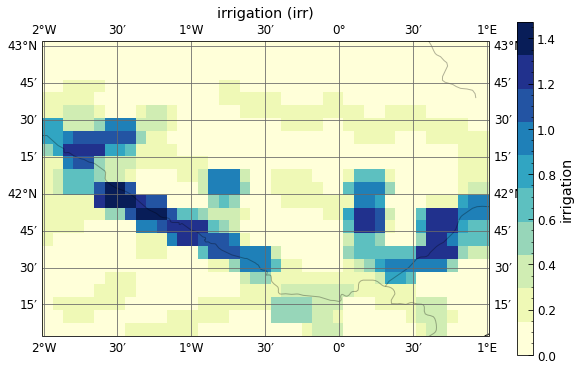

In [ ]:
#Display map of var for ds on restricted area
var='irrigation'
ds = ORCirr
# ds = std
latmin=36
latmax=44
lonmin=-9.5
lonmax=3

latmin=41
latmax=43
lonmin=-2
lonmax=1

#restrict ds to latmin, latmax, lonmin, lonmax
ds = ds.where(ds.lat >= latmin, drop=True)
ds = ds.where(ds.lat <= latmax, drop=True)
ds = ds.where(ds.lon >= lonmin, drop=True)
ds = ds.where(ds.lon <= lonmax, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=wet)
plt.title(var + ' (' + ds.name + ')')
ax.add_feature(rivers)


In [ ]:
#Display map of var for ds averaged on a given year
var='evap'
year=2012
ds = ORCnoirr
# ds = ds.where(ds['time.year'] == year, drop=True)
plotvar = ds[var].mean(dim='time')
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.PlateCarree())
ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
#use colormap reds
plotvar.plot(ax=ax, transform=ccrs.PlateCarree(), cmap=myvir)
plt.title(var + ' (' + ds.name + ')')

# Time series

In [ ]:
var='precip'

ds1=ORCnoirr
ds2=ORCirr
ds_list=[ds1, ds2]

year_max=2022
time_series(ds_list, var, year_max=year_max, in_title=var)
seasonal_cycle(ds_list, var, in_title=var)

In [ ]:
#Average time series
var='evap'
ds1=ORCirr
ds2=ORCnoirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).plot(ax=ax, label=ds2.name)
plt.title(var)
plt.legend()

In [ ]:
#Average seasonnal cycle
var='evap'
ds1=mORCirr
ds2=mORCnoirr
# ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
# ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()

ds1[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].mean(dim=['lon','lat']).groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)

months=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
ax.set_xticks(np.arange(1,13))
ax.set_xticklabels(months)
ax.set_ylabel('')
ax.set_xlabel('')
# plt.title(var)
plt.title('Average evaporation (mm/day)')
plt.title('Average evaporation (irrigated cells only, mm/day)')
plt.legend()

# Hydrographs en un point

In [ ]:
river_coordinates = {
    'Ebre': {'lon': 0.75, 'lat': 40.75},
    'Minho': {'lon': -8.75, 'lat': 42.25},
    'Tage': {'lon': -9.25, 'lat': 39.25},
    'Douro': {'lon': -8.75, 'lat': 41.25},
    'Guadiana': {'lon': -7.25, 'lat': 38.25},
    'Guadalquivir': {'lon': -6.25, 'lat': 36.75}
}
river_coordinates_native = {
    'Ebre': {'lon': 0.86, 'lat': 40.725},
    'Minho': {'lon': -8.875, 'lat': 41.86},
    'Tage': {'lon': -9.175, 'lat': 38.6875},
    'Douro': {'lon': -8.675, 'lat': 41.1375},
    'Guadiana': {'lon': -7.39, 'lat': 37.175},
    'Guadalquivir': {'lon': -6.34, 'lat': 36.79}
}

In [ ]:
#Time series
year_min=2003
year_max=2012
lon=-6.34
lat=36.79

var="hydrographs"
ds1=std
ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
ds2=natDIAG_R
ds2 = ds2.where(ds2['time.year'] >= year_min, drop=True).where(ds2['time.year'] <= year_max, drop=True)
#plot the time series of hydrographs at the point (lon,lat)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ax.set_ylabel('hydrographs')
# ds1[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds1.name)
ds2[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds2.name)
# ds2['runoff'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='runoff')
plt.title('hydrographs at (' + str(lon) + ',' + str(lat) + '), m³/s')
plt.legend()

In [ ]:
#Time series
year_min=2003
year_max=2012
lon=-8.875
lat=41.86
ds1=natDIAG_R
ds1 = ds1.where(ds1['time.year'] >= year_min, drop=True).where(ds1['time.year'] <= year_max, drop=True)
#plot the time series of hydrographs at the point (lon,lat)
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ds1['runoff'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='runoff',c='green')
ds1['drainage'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='drainage',c='brown')
# ['rain'].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label='rainfall',c='blue')
plt.title('Runoff and drainage at (' + str(lon) + ',' + str(lat) + '), mm/d')
plt.legend()

In [ ]:
#Cycle saisonnier (moyenne par jour de l'année)
var="hydrographs"
# # Guadiana
lon=-7.25
lat=38.25
ds1=std
ds2=natDIAG_R
fig = plt.figure(figsize=(10, 6))
ax = plt.axes()
ax.grid()
ax.set_xlabel('month')
ax.set_ylabel('hydrographs')
ax.set_title('hydrographs at (' + str(lon) + ',' + str(lat) + ')')
#compute the annual cycle of hydrographs at the point (lon,lat)
ds1[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.dayofyear').mean(dim='time').plot(ax=ax, label=ds1.name)
ds2[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.dayofyear').mean(dim='time').plot(ax=ax, label=ds2.name)
plt.legend()

In [ ]:
#cycle saisonnier pour 6 points de grille
var = "hydrographs"
ds1 = std
ds2 = natDIAG_R

# Create subplots for each river in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over rivers and plot hydrographs
for i, (river, coordinates) in enumerate(river_coordinates.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    #Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds1[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.month').mean(dim='time').plot(ax=ax, label=ds1.name)

for i, (river, coordinates) in enumerate(river_coordinates_native.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds2[var].sel(lon=lon, lat=lat, method='nearest').groupby('time.month').mean(dim='time').plot(ax=ax, label=ds2.name)
    
    ax.legend()
    #set subplot title to river name
    ax.set_title(river)

# Remove any remaining empty subplots
for i in range(len(river_coordinates), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Cycle saisonnier du débit à l'exutoire (m³/s, 2003-2012)")
plt.tight_layout()

In [ ]:
#série temporelle pour 6 points de grille
var = "hydrographs"
ds1 = natORC
ds2 = natDIAG_R

# Create subplots for each river in a 2x3 grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))

# Flatten the axes array for easier iteration
axes = axes.flatten()

# Iterate over rivers and plot hydrographs
for i, (river, coordinates) in enumerate(river_coordinates.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    # ds1[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds1.name)

for i, (river, coordinates) in enumerate(river_coordinates_native.items()):
    lon = coordinates['lon']
    lat = coordinates['lat']
    
    ax = axes[i]

    # Compute the annual cycle of hydrographs at the point (lon, lat) for each dataset
    ds2[var].sel(lon=lon, lat=lat, method='nearest').plot(ax=ax, label=ds2.name)
    
    ax.legend()
    #set subplot title to river name
    ax.set_title(river)

# Remove any remaining empty subplots
for i in range(len(river_coordinates), len(axes)):
    fig.delaxes(axes[i])

plt.suptitle("Série temporelle du débit à l'exutoire (m³/s)")
plt.tight_layout()